In [1]:
import numpy as np
import pandas as pd
import sklearn
import lightgbm
import xgboost
import matplotlib

In [2]:
# Core libraries
import os
import re
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization - FIX for notebook display issues
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt
import seaborn as sns
# Re-enable inline display for Jupyter/VS Code
%matplotlib inline

# NLP & Text Processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# Models
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Load datasets
DATASET_FOLDER = 'dataset/'

train = pd.read_csv(os.path.join(DATASET_FOLDER, 'train.csv'))
test = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

print("First few rows:")
display(train.head(3))
print("Data Info:")
print(train.info())

Training data shape: (75000, 4)
Test data shape: (75000, 3)
First few rows:


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)\nValue: 72.0\nUnit: Fl Oz\n",https://m.media-amazon.com/images/I/51mo8htwTHL.jpg,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butter Cookies, 8 Ounce (Pack of 4)\nBullet Point 1: Or...",https://m.media-amazon.com/images/I/71YtriIHAAL.jpg,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy Chicken with Rice, 1.9 Ounce (Pack of 6)\nBullet ...",https://m.media-amazon.com/images/I/51+PFEe-w-L.jpg,1.97


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        75000 non-null  int64  
 1   catalog_content  75000 non-null  object 
 2   image_link       75000 non-null  object 
 3   price            75000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB
None


Price Statistics:
count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64

Price Range: $0.13 - $2796.00
Price Median: $14.00
Price Mean: $23.65


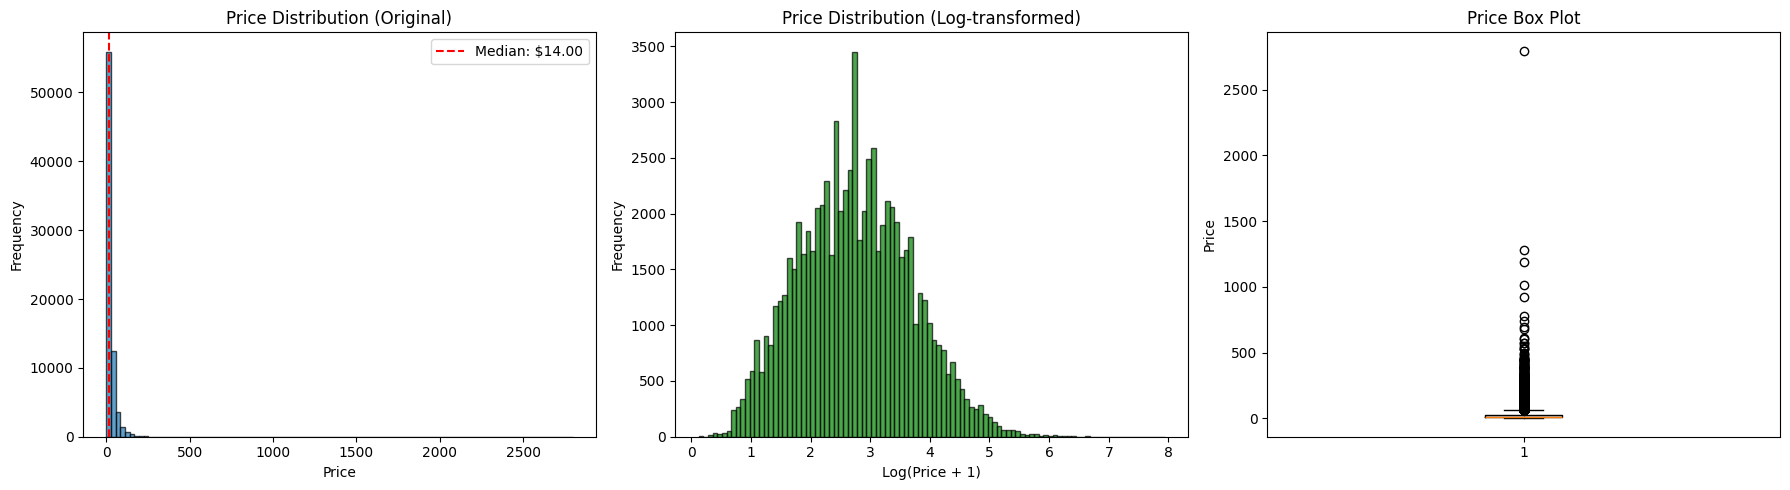


Number of outliers (price > $500): 17


In [4]:
# Price statistics and distribution
print("Price Statistics:")
print(train['price'].describe())

print(f"\nPrice Range: ${train['price'].min():.2f} - ${train['price'].max():.2f}")
print(f"Price Median: ${train['price'].median():.2f}")
print(f"Price Mean: ${train['price'].mean():.2f}")

# Visualize price distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original price distribution
axes[0].hist(train['price'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution (Original)')
axes[0].axvline(train['price'].median(), color='red', linestyle='--', label=f'Median: ${train["price"].median():.2f}')
axes[0].legend()

# Log-transformed price
axes[1].hist(np.log1p(train['price']), bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Distribution (Log-transformed)')

# Box plot
axes[2].boxplot(train['price'], vert=True)
axes[2].set_ylabel('Price')
axes[2].set_title('Price Box Plot')

plt.tight_layout()
plt.show()

print(f"\nNumber of outliers (price > $500): {(train['price'] > 500).sum()}")

In [5]:
# Examine catalog content
print("Sample Catalog Content:\n")
for i in range(3):
    print(f"\nSample {i+1} (Price: ${train['price'].iloc[i]:.2f})")
    print(train['catalog_content'].iloc[i])

Sample Catalog Content:


Sample 1 (Price: $4.89)
Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)
Value: 72.0
Unit: Fl Oz


Sample 2 (Price: $13.12)
Item Name: Salerno Cookies, The Original Butter Cookies, 8 Ounce (Pack of 4)
Bullet Point 1: Original Butter Cookies: Classic butter cookies made with real butter
Bullet Point 2: Variety Pack: Includes 4 boxes with 32 cookies total
Bullet Point 3: Occasion Perfect: Delicious cookies for birthdays, weddings, anniversaries
Bullet Point 4: Shareable Treats: Fun to give and enjoy with friends and family
Bullet Point 5: Salerno Brand: Trusted brand of delicious butter cookies since 1925
Value: 32.0
Unit: Ounce


Sample 3 (Price: $1.97)
Item Name: Bear Creek Hearty Soup Bowl, Creamy Chicken with Rice, 1.9 Ounce (Pack of 6)
Bullet Point 1: Loaded with hearty long grain wild rice and vegetables
Bullet Point 2: Full of hearty goodness
Bullet Point 3: Single serve bowls
Bullet Point 4: Easy to prepare mix
Bullet Point 5: 0 grams t

In [6]:
def extract_structured_features(df):
    """
    Extract structured features from catalog_content format
    Focuses on: Value, Unit, Brand, Pack Size, Categories
    """
    df = df.copy()
    
    print("Extracting structured features...")
    
    # 1. Extract Value and Unit (KEY FEATURES from structured format)
    # Pattern: "Value: 72.0" or "Value: 32.0"
    df['value'] = df['catalog_content'].str.extract(r'Value:\s*([\d.]+)', expand=False).astype(float)
    df['value'] = df['value'].fillna(1.0)  # Default to 1 if missing
    
    # Extract Unit (Oz, Ounce, Pound, Count, etc.)
    df['unit'] = df['catalog_content'].str.extract(r'Unit:\s*(\w+)', expand=False)
    df['unit'] = df['unit'].fillna('Unknown')
    
    # 2. Extract Brand Name (from Item Name field)
    def extract_brand(text):
        try:
            item_name = re.search(r'Item Name:\s*(.+?)(?:\n|$)', str(text))
            if item_name:
                name = item_name.group(1).strip()
                # Get first 1-2 words as brand
                words = name.split()[:2]
                return ' '.join(words) if words else 'Unknown'
        except:
            pass
        return 'Unknown'
    
    df['brand'] = df['catalog_content'].apply(extract_brand)
    
    # 3. Extract Pack Size (e.g., "Pack of 6", "Pack of 12")
    df['pack_size'] = df['catalog_content'].str.extract(r'[Pp]ack of (\d+)', expand=False).astype(float)
    df['pack_size'] = df['pack_size'].fillna(1.0)
    
    # 4. Total Quantity (Value * Pack Size)
    df['total_quantity'] = df['value'] * df['pack_size']
    
    # 5. Number of Bullet Points
    df['num_bullet_points'] = df['catalog_content'].str.count('Bullet Point')
    
    # 6. Unit type categorization
    weight_units = ['Ounce', 'Oz', 'Pound', 'Lb', 'Gram', 'Kg']
    volume_units = ['Fl Oz', 'Liter', 'Gallon', 'Ml']
    
    df['is_weight_unit'] = df['unit'].isin(weight_units).astype(int)
    df['is_volume_unit'] = df['unit'].isin(volume_units).astype(int)
    df['is_count_unit'] = (df['unit'] == 'Count').astype(int)
    
    # 7. Basic Text Statistics
    df['text_length'] = df['catalog_content'].str.len()
    df['word_count'] = df['catalog_content'].str.split().str.len()
    df['avg_word_length'] = df['catalog_content'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
    df['line_count'] = df['catalog_content'].str.count('\n') + 1
    df['numeric_count'] = df['catalog_content'].str.findall(r'\d+').str.len()
    
    print(f"Structured features extracted: {len([col for col in df.columns if col not in ['sample_id', 'catalog_content', 'image_link', 'price']])}")
    
    return df

# Apply structured feature engineering
print("PART 3: STRUCTURED FEATURE EXTRACTION")

train_features = extract_structured_features(train)
test_features = extract_structured_features(test)

print("\nExtracted features:")
new_cols = [col for col in train_features.columns if col not in train.columns]
print(new_cols)

PART 3: STRUCTURED FEATURE EXTRACTION
Extracting structured features...
Structured features extracted: 14
Extracting structured features...
Structured features extracted: 14

Extracted features:
['value', 'unit', 'brand', 'pack_size', 'total_quantity', 'num_bullet_points', 'is_weight_unit', 'is_volume_unit', 'is_count_unit', 'text_length', 'word_count', 'avg_word_length', 'line_count', 'numeric_count']


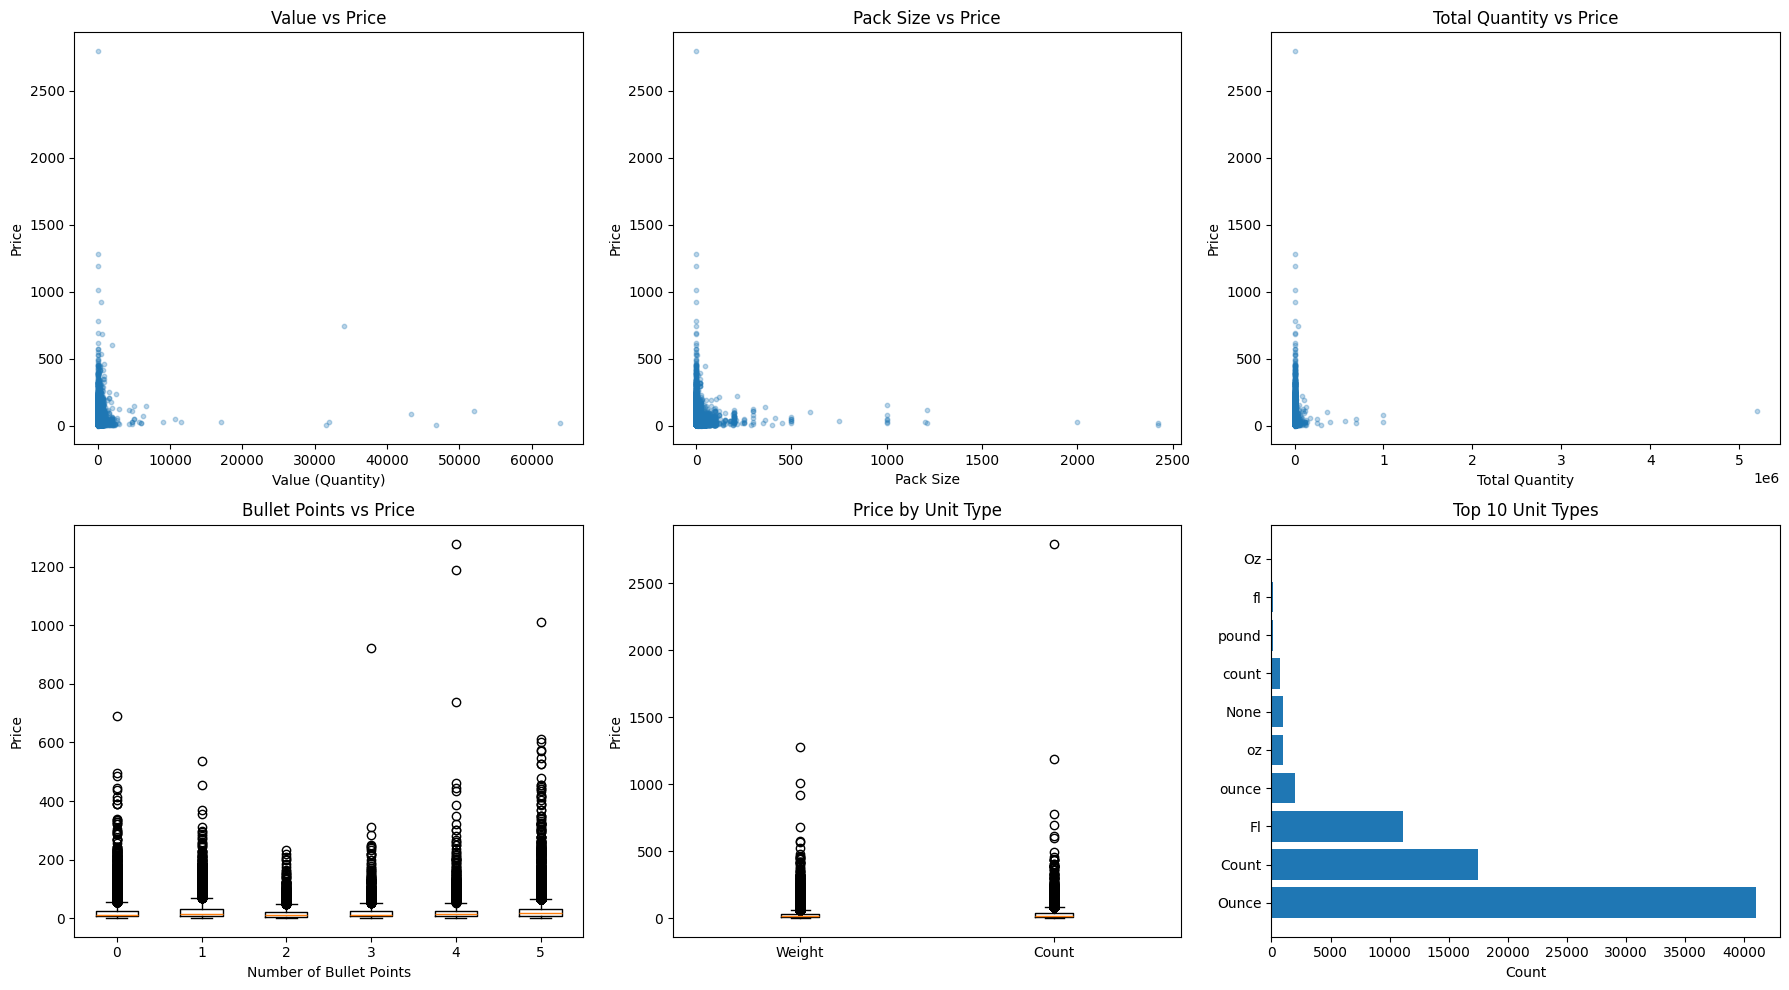


Feature Correlations with Price:
price                1.000000
text_length          0.146752
word_count           0.144423
numeric_count        0.121226
is_count_unit        0.109825
value                0.064520
avg_word_length      0.053242
line_count           0.051155
num_bullet_points    0.021906
pack_size            0.019729
total_quantity       0.014735
sample_id           -0.025731
is_weight_unit      -0.058554
is_volume_unit            NaN
Name: price, dtype: float64


In [7]:
# Visualize key features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Value vs Price
axes[0, 0].scatter(train_features['value'], train_features['price'], alpha=0.3, s=10)
axes[0, 0].set_xlabel('Value (Quantity)')
axes[0, 0].set_ylabel('Price')
axes[0, 0].set_title('Value vs Price')

# Pack size vs Price
axes[0, 1].scatter(train_features['pack_size'], train_features['price'], alpha=0.3, s=10)
axes[0, 1].set_xlabel('Pack Size')
axes[0, 1].set_ylabel('Price')
axes[0, 1].set_title('Pack Size vs Price')

# Total quantity vs Price
axes[0, 2].scatter(train_features['total_quantity'], train_features['price'], alpha=0.3, s=10)
axes[0, 2].set_xlabel('Total Quantity')
axes[0, 2].set_ylabel('Price')
axes[0, 2].set_title('Total Quantity vs Price')

# Bullet points vs Price
axes[1, 0].boxplot([train_features[train_features['num_bullet_points'] == i]['price'].values 
                     for i in range(6)], labels=range(6))
axes[1, 0].set_xlabel('Number of Bullet Points')
axes[1, 0].set_ylabel('Price')
axes[1, 0].set_title('Bullet Points vs Price')

# Unit types vs Price
unit_types = ['is_weight_unit', 'is_volume_unit', 'is_count_unit']
unit_data = []
unit_labels = []
for unit_type in unit_types:
    if train_features[train_features[unit_type] == 1]['price'].shape[0] > 0:
        unit_data.append(train_features[train_features[unit_type] == 1]['price'].values)
        unit_labels.append(unit_type.replace('is_', '').replace('_unit', '').title())

if len(unit_data) > 0:
    axes[1, 1].boxplot(unit_data, labels=unit_labels)
    axes[1, 1].set_ylabel('Price')
    axes[1, 1].set_title('Price by Unit Type')
else:
    axes[1, 1].text(0.5, 0.5, 'No data', ha='center', va='center')
    axes[1, 1].set_title('Price by Unit Type')

# Unit type distribution
unit_counts = train_features['unit'].value_counts().head(10)
axes[1, 2].barh(unit_counts.index, unit_counts.values)
axes[1, 2].set_xlabel('Count')
axes[1, 2].set_title('Top 10 Unit Types')

plt.tight_layout()
plt.show()

# Correlation with price
numeric_cols = train_features.select_dtypes(include=[np.number]).columns
correlations = train_features[numeric_cols].corr()['price'].sort_values(ascending=False)
print("\nFeature Correlations with Price:")
print(correlations.head(15))

In [8]:
# Advanced Text Feature extraction(SEMANTIC FEATURES)
def extract_semantic_text_features(df):
    """
    Extract SEMANTIC features from text (beyond structured fields)
    Focus: Premium indicators, categories, specifications
    """
    df = df.copy()
    
    print("\nExtracting semantic text features...")
    
    text_col = df['catalog_content'].str.lower()
    
    # 1. Premium/Quality Indicators
    premium_keywords = ['premium', 'luxury', 'deluxe', 'professional', 'pro', 
                        'ultra', 'plus', 'max', 'advanced', 'superior', 'organic']
    df['is_premium'] = text_col.str.contains('|'.join(premium_keywords)).astype(int)
    
    # 2. Category Detection(8 major categories)
    category_keywords = {
        'electronics': ['laptop', 'phone', 'tablet', 'camera', 'headphone', 'speaker', 
                        'charger', 'cable', 'wireless', 'bluetooth', 'usb', 'battery', 'electronic'],
        'home': ['furniture', 'decor', 'kitchen', 'appliance', 'cookware', 'pan',
                 'pot', 'dish', 'cup', 'plate'],
        'fashion': ['shirt', 'pants', 'dress', 'shoe', 'bag', 'wallet', 'watch',
                    'clothing', 'apparel', 'wear'],
        'beauty': ['cosmetic', 'makeup', 'skincare', 'perfume', 'lotion', 'cream',
                   'shampoo', 'conditioner', 'soap', 'beauty', 'skin', 'hair'],
        'toys': ['toy', 'game', 'puzzle', 'doll', 'action figure', 'lego', 'play'],
        'books': ['book', 'novel', 'guide', 'manual', 'textbook', 'paperback'],
        'sports': ['fitness', 'gym', 'yoga', 'sports', 'exercise', 'workout', 'training'],
        'food': ['food', 'snack', 'coffee', 'tea', 'chocolate', 'candy', 'sauce', 
                 'cookie', 'flavor', 'taste', 'ingredient', 'organic']
    }
    
    for category, keywords in category_keywords.items():
        df[f'cat_{category}'] = text_col.str.contains('|'.join(keywords)).astype(int)
    
    # 3. Specification Extraction (storage, weight, dimensions)
    spec_patterns = {
        'storage_gb': r'(\d+)\s*(?:gb|gigabyte)',
        'weight_oz': r'(\d+\.?\d*)\s*(?:oz|ounce)',
        'weight_lb': r'(\d+\.?\d*)\s*(?:lb|pound)',
        'volume_ml': r'(\d+)\s*(?:ml|milliliter)',
        'volume_l': r'(\d+\.?\d*)\s*(?:l|liter)',
        'size_inch': r'(\d+\.?\d*)\s*(?:inch|in|")',
        'size_cm': r'(\d+\.?\d*)\s*(?:cm|centimeter)',
        'power_w': r'(\d+)\s*(?:w|watt)',
        'voltage': r'(\d+)\s*(?:v|volt)'
    }
    
    for key, pattern in spec_patterns.items():
        df[key] = text_col.str.extract(pattern, expand=False).astype(float).fillna(0)
    
    # 4. Material & Color Detection
    materials = ['plastic', 'metal', 'wood', 'glass', 'ceramic', 'stainless steel',
                 'aluminum', 'leather', 'cotton', 'polyester', 'nylon', 'silicone']
    df['has_material'] = text_col.str.contains('|'.join(materials)).astype(int)
    
    colors = ['black', 'white', 'red', 'blue', 'green', 'yellow', 'silver', 'gold',
              'gray', 'brown', 'pink', 'purple', 'orange']
    df['has_color'] = text_col.str.contains('|'.join(colors)).astype(int)
    
    # 5. Text Quality Metrics
    df['caps_ratio'] = df['catalog_content'].apply(
        lambda x: sum(c.isupper() for c in str(x)) / (len(str(x)) + 1)
    )
    df['digit_count'] = df['catalog_content'].str.count(r'\d')
    df['special_char_count'] = df['catalog_content'].apply(
        lambda x: sum(not c.isalnum() and not c.isspace() for c in str(x))
    )
    
    # 6. Detect bulk/multi-pack patterns
    df['has_pack_keywords'] = text_col.str.contains(
        r'pack of|set of|box of|bundle|multipack|count'
    ).astype(int)
    
    print(f" Semantic features extracted: {len([c for c in df.columns if c.startswith('cat_') or c in ['is_premium', 'has_material', 'has_color', 'caps_ratio', 'digit_count', 'special_char_count', 'has_pack_keywords']] + [k for k in spec_patterns.keys()])}")
    
    return df

# Apply semantic feature extraction
train_features = extract_semantic_text_features(train_features)
test_features = extract_semantic_text_features(test_features)

# Store extracted features for later
semantic_feature_names = [
    'is_premium', 'cat_electronics', 'cat_home', 'cat_fashion', 'cat_beauty',
    'cat_toys', 'cat_books', 'cat_sports', 'cat_food',
    'storage_gb', 'weight_oz', 'weight_lb', 'volume_ml', 'volume_l',
    'size_inch', 'size_cm', 'power_w', 'voltage',
    'has_material', 'has_color', 'caps_ratio', 'digit_count', 
    'special_char_count', 'has_pack_keywords'
]

print(f"\n Semantic Feature Summary:")
print(f"   Premium products: {train_features['is_premium'].sum()} ({train_features['is_premium'].mean()*100:.1f}%)")
print(f"   Electronics: {train_features['cat_electronics'].sum()}")
print(f"   Food: {train_features['cat_food'].sum()}")
print(f"   Has material info: {train_features['has_material'].sum()}")
print(f"   Has color info: {train_features['has_color'].sum()}")


Extracting semantic text features...
 Semantic features extracted: 24

Extracting semantic text features...
 Semantic features extracted: 24

 Semantic Feature Summary:
   Premium products: 51387 (68.5%)
   Electronics: 640
   Food: 59116
   Has material info: 5700
   Has color info: 43484


In [9]:
# Text Cleaning for TF-IDF

def clean_text_for_tfidf(text):
    """Clean text while preserving important patterns"""
    text = str(text).lower()
    # Remove "bullet point" labels
    text = re.sub(r'bullet\s*point\s*\d*:?', '', text)
    # Remove field labels but keep content
    text = re.sub(r'(item name|value|unit|pack of):', '', text)
    # Remove excessive special characters but keep spaces and alphanumeric
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

train_features['cleaned_text'] = train_features['catalog_content'].apply(clean_text_for_tfidf)
test_features['cleaned_text'] = test_features['catalog_content'].apply(clean_text_for_tfidf)

print(f" Text cleaned for {len(train_features)} training samples")
print(f"\nSample cleaned text:")
print(train_features['cleaned_text'].iloc[0][:200] + "...")

 Text cleaned for 75000 training samples

Sample cleaned text:
la victoria green taco sauce mild 12 ounce pack of 6 72 0 fl oz...


In [10]:
# TF-IDF Vectorization - IMPROVED with 8000 features!

# Configuration for maximum performance
tfidf = TfidfVectorizer(
    max_features=8000,      # 16x more features than before!
    ngram_range=(1, 3),     # Include trigrams for phrases like "pack of 12"
    min_df=3,               # Word must appear in at least 3 documents
    max_df=0.85,            # Ignore words in >85% of documents
    stop_words='english',
    sublinear_tf=True,      # Use log scaling (reduces impact of very frequent words)
    norm='l2',              # L2 normalization
    strip_accents='unicode' # Handle special characters
)

# Fit on combined data for consistency
print("Fitting TF-IDF vectorizer.")
all_text = pd.concat([train_features['cleaned_text'], test_features['cleaned_text']])
tfidf.fit(all_text)

# Transform
print("Transforming training data.")
train_tfidf = tfidf.transform(train_features['cleaned_text'])

print("Transforming test data...")
test_tfidf = tfidf.transform(test_features['cleaned_text'])

print(f"\n TF-IDF matrix created!")
print(f"   Shape: {train_tfidf.shape}")
print(f"   Vocabulary size: {len(tfidf.vocabulary_)}")
print(f"   Sparsity: {(1 - train_tfidf.nnz / (train_tfidf.shape[0] * train_tfidf.shape[1]))*100:.2f}%")

# Show top TF-IDF terms
print("\nTop 20 TF-IDF terms:")
feature_names = tfidf.get_feature_names_out()
avg_tfidf = train_tfidf.mean(axis=0).A1
top_indices = avg_tfidf.argsort()[-20:][::-1]
for idx in top_indices:
    print(f"  {feature_names[idx]}: {avg_tfidf[idx]:.4f}")

Fitting TF-IDF vectorizer.
Transforming training data.
Transforming test data...

 TF-IDF matrix created!
   Shape: (75000, 8000)
   Vocabulary size: 8000
   Sparsity: 99.04%

Top 20 TF-IDF terms:
  ounce: 0.0311
  oz: 0.0296
  pack: 0.0247
  count: 0.0211
  free: 0.0209
  product: 0.0195
  flavor: 0.0180
  12: 0.0175
  fl: 0.0166
  fl oz: 0.0165
  description: 0.0164
  product description: 0.0163
  organic: 0.0157
  tea: 0.0154
  gluten: 0.0139
  natural: 0.0136
  perfect: 0.0135
  taste: 0.0133
  gluten free: 0.0132
  chocolate: 0.0128


In [11]:
# SVD - Optional Dimensionality Reduction
USE_SVD = False

if USE_SVD:
    print("Applying TruncatedSVD with 300 components...")
    svd = TruncatedSVD(n_components=300, random_state=RANDOM_STATE)
    train_svd = svd.fit_transform(train_tfidf)
    test_svd = svd.transform(test_tfidf)
    
    print(f"SVD features created: {train_svd.shape}")
    print(f"Explained variance: {svd.explained_variance_ratio_.sum():.2%}")
    
    # Convert to DataFrame
    train_svd_df = pd.DataFrame(train_svd, columns=[f'tfidf_{i}' for i in range(300)])
    test_svd_df = pd.DataFrame(test_svd, columns=[f'tfidf_{i}' for i in range(300)])
    print(" Using SVD-compressed features")
else:
    # Use TF-IDF as-is (sparse to dense conversion)
    print("Converting TF-IDF sparse matrix to dense")
    print(" This may take a moment with 8000 features")
    
    train_svd_df = pd.DataFrame(
        train_tfidf.toarray(),
        columns=[f'tfidf_{i}' for i in range(train_tfidf.shape[1])]
    )
    test_svd_df = pd.DataFrame(
        test_tfidf.toarray(),
        columns=[f'tfidf_{i}' for i in range(test_tfidf.shape[1])]
    )
    print(" Using full TF-IDF features (no compression)")

print(f"\nText features ready: {train_svd_df.shape}")

Converting TF-IDF sparse matrix to dense
 This may take a moment with 8000 features
 Using full TF-IDF features (no compression)

Text features ready: (75000, 8000)


In [12]:
# Target Encoding for Brand (using brand from Part 3)
print("\n Target Encoding for Brand...\n")

# Calculate mean price per brand (on training data only!)
brand_price_map = train_features.groupby('brand')['price'].mean().to_dict()

# Add smoothing to avoid overfitting
global_mean_price = train_features['price'].mean()
smoothing_factor = 10  # Higher = more conservative

def smooth_target_encode(brand, price_map, global_mean, smoothing):
    if brand not in price_map:
        return global_mean
    
    brand_mean = price_map[brand]
    brand_count = (train_features['brand'] == brand).sum()
    
    # Smooth with global mean
    return (brand_count * brand_mean + smoothing * global_mean) / (brand_count + smoothing)

# Apply to both datasets
train_features['brand_target_encoded'] = train_features['brand'].apply(
    lambda x: smooth_target_encode(x, brand_price_map, global_mean_price, smoothing_factor)
)

test_features['brand_target_encoded'] = test_features['brand'].apply(
    lambda x: smooth_target_encode(x, brand_price_map, global_mean_price, smoothing_factor)
)

print(" Target encoding complete!")
print(f"\nTop 10 brands by average price:")
brand_prices = train_features.groupby('brand')['price'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(10)
print(brand_prices)


 Target Encoding for Brand...

 Target encoding complete!

Top 10 brands by average price:
                             mean  count
brand                                   
4Patriots 1-Year         2796.000      1
495 days                 1188.000      1
Numanna Family            779.250      1
China Beauty              768.430      2
Topps Juicy               691.160      1
Beverage/Topping Heated   613.580      1
Mega Bulk                 600.590      1
Organic Pistachios        501.495      2
Jenny Silks               496.280      1
Royal Amber               487.500      4


In [13]:
# Define which features to use -structured features
structured_features = [
    'value', 'pack_size', 'total_quantity', 'num_bullet_points',
    'is_weight_unit', 'is_volume_unit', 'is_count_unit',
    'text_length', 'word_count', 'avg_word_length', 'line_count', 'numeric_count'
]

# Categorical features that need encoding
categorical_features = ['unit', 'brand']

print("\n Encoding categorical features...")
# Encode categorical features
for col in categorical_features:
    if col in train_features.columns:
        le = LabelEncoder()
        # Combine train and test for consistent encoding
        combined = pd.concat([train_features[col], test_features[col]])
        le.fit(combined)
        
        train_features[f'{col}_encoded'] = le.transform(train_features[col])
        test_features[f'{col}_encoded'] = le.transform(test_features[col])
        print(f"    Encoded: {col} ({len(le.classes_)} unique values)")

encoded_features = ['unit_encoded', 'brand_encoded', 'brand_target_encoded']

# Semantic features from Part 4
semantic_features = [
    'is_premium', 'cat_electronics', 'cat_home', 'cat_fashion', 'cat_beauty',
    'cat_toys', 'cat_books', 'cat_sports', 'cat_food',
    'storage_gb', 'weight_oz', 'weight_lb', 'volume_ml', 'volume_l',
    'size_inch', 'size_cm', 'power_w', 'voltage',
    'has_material', 'has_color', 'caps_ratio', 'digit_count', 
    'special_char_count', 'has_pack_keywords'
]

# Filter semantic features that actually exist
existing_semantic = [f for f in semantic_features if f in train_features.columns]

print(f"\nPreparing feature sets...")
print(f"   Structured features: {len(structured_features)}")
print(f"   Encoded categorical: {len(encoded_features)}")
print(f"   Semantic features: {len(existing_semantic)}")
print(f"   TF-IDF features: {train_svd_df.shape[1]}")

# Combine all numeric features (structured + encoded + semantic)
all_numeric_features = structured_features + encoded_features + existing_semantic

# Create base feature matrices
X_train_base = train_features[all_numeric_features].copy()
X_test_base = test_features[all_numeric_features].copy()

# Add TF-IDF features
X_train = pd.concat([
    X_train_base.reset_index(drop=True), 
    train_svd_df.reset_index(drop=True)
], axis=1)

X_test = pd.concat([
    X_test_base.reset_index(drop=True), 
    test_svd_df.reset_index(drop=True)
], axis=1)

# Target variable (log-transform for better distribution)
y_train = np.log1p(train_features['price'].values)

print(f"\n Final feature matrix prepared!")
print(f"   Training shape: {X_train.shape}")
print(f"   Test shape: {X_test.shape}")
print(f"   Target transformation: log(price + 1)")

print(f"\n Feature Breakdown ({X_train.shape[1]} total features):")
print(f"   Structured: {len(structured_features)}")
print(f"   Encoded categorical: {len(encoded_features)}")
print(f"   Semantic: {len(existing_semantic)}")
print(f"   TF-IDF: {train_svd_df.shape[1]}")



 Encoding categorical features...
    Encoded: unit (118 unique values)


    Encoded: brand (49466 unique values)

Preparing feature sets...
   Structured features: 12
   Encoded categorical: 3
   Semantic features: 24
   TF-IDF features: 8000

 Final feature matrix prepared!
   Training shape: (75000, 8039)
   Test shape: (75000, 8039)
   Target transformation: log(price + 1)

 Feature Breakdown (8039 total features):
   Structured: 12
   Encoded categorical: 3
   Semantic: 24
   TF-IDF: 8000


In [14]:
def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error
    Lower is better (0-200% range)
    """
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred)
    # Avoid division by zero
    denominator = np.where(denominator == 0, 1, denominator)
    return np.mean(diff / denominator) * 100

def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Comprehensive evaluation
    """
    # If predictions are log-transformed, convert back
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    
    smape_score = smape(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true_orig, y_pred_orig)
    
    
    print(f"{model_name} Performance:")
    print(f"SMAPE:        {smape_score:.4f}%  (Primary Metric)")
    print(f"RMSE:         ${rmse:.2f}")
    print(f"MAE:          ${mae:.2f}")
    print(f"R² Score:     {r2:.4f}")
    
    return smape_score

In [16]:
# Split data for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Data split:")
print(f"   Training:   {X_tr.shape[0]} samples")
print(f"   Validation: {X_val.shape[0]} samples")
print(f"   Test:       {X_test.shape[0]} samples")

Data split:
   Training:   60000 samples
   Validation: 15000 samples
   Test:       75000 samples


In [ ]:
print("\nTraining LightGBM model with optimized hyperparameters\n")

from lightgbm import log_evaluation

# IMPROVED hyperparameters
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.015,
    'num_leaves': 64,
    'max_depth': 12,
    'min_child_samples': 20,
    'subsample': 0.75,
    'subsample_freq': 1,
    'colsample_bytree': 0.85,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'n_estimators': 8000,
    'random_state': RANDOM_STATE,
    'verbose': -1
}

# Train model
lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False), log_evaluation(period=100)]
)

# Predict
lgb_val_pred = lgb_model.predict(X_val)
lgb_test_pred = lgb_model.predict(X_test)

# Evaluate
lgb_smape = evaluate_model(y_val, lgb_val_pred, "LightGBM")

print(f"\n LightGBM trained with {lgb_model.best_iteration_} iterations")
print(f"   (Early stopping at iteration {lgb_model.best_iteration_})")

PART 7: MODEL TRAINING

Training LightGBM model with optimized hyperparameters...

 Hyperparameters:
   objective: regression
   metric: rmse
   boosting_type: gbdt
   learning_rate: 0.015
   num_leaves: 64
   max_depth: 12
   min_child_samples: 20
   subsample: 0.75
   subsample_freq: 1
   colsample_bytree: 0.85
   reg_alpha: 1.0
   reg_lambda: 1.0
   n_estimators: 8000
   random_state: 42
   verbose: -1
[100]	valid_0's rmse: 0.618321
[100]	valid_0's rmse: 0.618321
[200]	valid_0's rmse: 0.571164
[200]	valid_0's rmse: 0.571164
[300]	valid_0's rmse: 0.55991
[300]	valid_0's rmse: 0.55991
[400]	valid_0's rmse: 0.55499
[400]	valid_0's rmse: 0.55499
[500]	valid_0's rmse: 0.552293
[500]	valid_0's rmse: 0.552293
[600]	valid_0's rmse: 0.54987
[600]	valid_0's rmse: 0.54987
[700]	valid_0's rmse: 0.547949
[700]	valid_0's rmse: 0.547949
[800]	valid_0's rmse: 0.546376
[800]	valid_0's rmse: 0.546376
[900]	valid_0's rmse: 0.545141
[900]	valid_0's rmse: 0.545141
[1000]	valid_0's rmse: 0.543956
[1000]	


Top 20 Most Important Features:
                   feature  importance
14    brand_target_encoded       14882
9          avg_word_length        7976
35              caps_ratio        7480
13           brand_encoded        7325
0                    value        7164
2           total_quantity        6916
25               weight_oz        5786
5121            tfidf_5082        4930
5224            tfidf_5185        4066
5171            tfidf_5132        4000
7              text_length        3781
37      special_char_count        3511
36             digit_count        3397
8               word_count        2927
5795            tfidf_5756        2153
11           numeric_count        2116
2206            tfidf_2167        1903
2840            tfidf_2801        1887
3009            tfidf_2970        1710
1                pack_size        1660

                   feature  importance
14    brand_target_encoded       14882
9          avg_word_length        7976
35              caps_ratio    

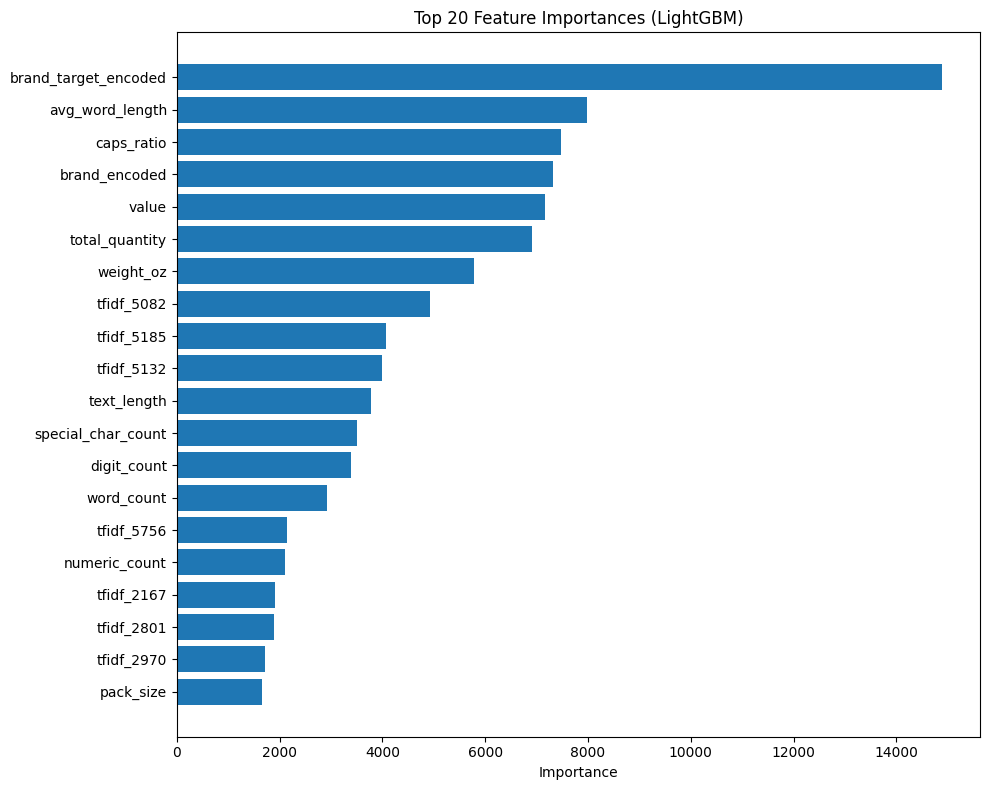

In [ ]:
# Feature importance from LightGBM
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(feature_importance.head(20)['feature'], feature_importance.head(20)['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
xgb_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.02,
    'max_depth': 6,
    'min_child_weight': 5,
    'subsample': 0.75,
    'colsample_bytree': 0.3,
    'colsample_bylevel': 0.5,
    'reg_alpha': 1.5,
    'reg_lambda': 2.0, 
    'gamma': 0.1,
    'n_estimators': 3000,
    'random_state': RANDOM_STATE,
    'tree_method': 'hist',
    'max_bin': 256
}

xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=100,
    verbose=100
)

xgb_val_pred = xgb_model.predict(X_val)
xgb_test_pred = xgb_model.predict(X_test)

xgb_smape = evaluate_model(y_val, xgb_val_pred, "XGBoost")

print(f"Best iteration: {xgb_model.best_iteration}")

Training XGBoost model...

[0]	validation_0-rmse:0.94869
[0]	validation_0-rmse:0.94869
[100]	validation_0-rmse:0.70637
[100]	validation_0-rmse:0.70637
[200]	validation_0-rmse:0.63027
[200]	validation_0-rmse:0.63027
[300]	validation_0-rmse:0.60108
[300]	validation_0-rmse:0.60108
[400]	validation_0-rmse:0.58663
[400]	validation_0-rmse:0.58663
[500]	validation_0-rmse:0.57648
[500]	validation_0-rmse:0.57648
[600]	validation_0-rmse:0.57105
[600]	validation_0-rmse:0.57105
[700]	validation_0-rmse:0.56689
[700]	validation_0-rmse:0.56689
[800]	validation_0-rmse:0.56462
[800]	validation_0-rmse:0.56462
[900]	validation_0-rmse:0.56301
[900]	validation_0-rmse:0.56301
[1000]	validation_0-rmse:0.56155
[1000]	validation_0-rmse:0.56155
[1100]	validation_0-rmse:0.56041
[1100]	validation_0-rmse:0.56041
[1200]	validation_0-rmse:0.55939
[1200]	validation_0-rmse:0.55939
[1300]	validation_0-rmse:0.55848
[1300]	validation_0-rmse:0.55848
[1400]	validation_0-rmse:0.55748
[1400]	validation_0-rmse:0.55748
[1500]	

In [ ]:
# Model performance comparison
model_scores = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost'],
    'SMAPE': [lgb_smape, xgb_smape]
}).sort_values('SMAPE')

print("\nModel Performance Comparison:")
print(model_scores.to_string(index=False))





Model Performance Comparison:
   Model     SMAPE
LightGBM 39.167319
 XGBoost 41.543746


In [ ]:
# Weighted ensemble based on performance
print("\nCreating Ensemble Model...\n")

# Calculate weights inversely proportional to SMAPE
weights = 1 / np.array([lgb_smape, xgb_smape])
weights = weights / weights.sum()  # Normalize

print(f"Ensemble weights:")
print(f"  LightGBM: {weights[0]:.3f}")
print(f"  XGBoost:  {weights[1]:.3f}")

# Ensemble predictions (weighted average)
ensemble_val_pred = (
    weights[0] * lgb_val_pred +
    weights[1] * xgb_val_pred
)

ensemble_test_pred = (
    weights[0] * lgb_test_pred +
    weights[1] * xgb_test_pred
)

# Evaluate ensemble
ensemble_smape = evaluate_model(y_val, ensemble_val_pred, "ENSEMBLE (LightGBM + XGBoost)")

print("ENSEMBLE PERFORMANCE SUMMARY")
print(f"   LightGBM:          {lgb_smape:.4f}%")
print(f"   XGBoost:           {xgb_smape:.4f}%")
print(f"   Best single model: {model_scores.iloc[0]['SMAPE']:.4f}%")
print(f"   Ensemble:          {ensemble_smape:.4f}%")
improvement = model_scores.iloc[0]['SMAPE'] - ensemble_smape
print(f"   Improvement:       {improvement:+.4f}%")


Creating Ensemble Model...

Ensemble weights:
  LightGBM: 0.515
  XGBoost:  0.485
ENSEMBLE (LightGBM + XGBoost) Performance:
SMAPE:        40.0090%  (Primary Metric)
RMSE:         $29.35
MAE:          $8.89
R² Score:     0.4292

ENSEMBLE PERFORMANCE SUMMARY
   LightGBM:          39.1673%
   XGBoost:           41.5437%
   Best single model: 39.1673%
   Ensemble:          40.0090%
   Improvement:       -0.8417%



Prediction Statistics:
             Actual     Predicted         Error     Abs_Error  \
count  15000.000000  15000.000000  15000.000000  15000.000000   
mean      23.843736     20.108199      3.735537      8.888616   
std       38.849779     20.743915     29.113795     27.974192   
min        0.360000      0.890881   -135.972731      0.001652   
25%        6.690000      7.839541     -2.925243      1.524681   
50%       13.990000     13.100316     -0.203456      3.672507   
75%       28.733750     24.842245      5.163971      8.885423   
max     2796.000000    231.094688   2609.530569   2609.530569   

       Percentage_Error  
count      15000.000000  
mean          54.424078  
std          113.422757  
min            0.004504  
25%           12.491727  
50%           28.690389  
75%           56.932503  
max         4679.458564  


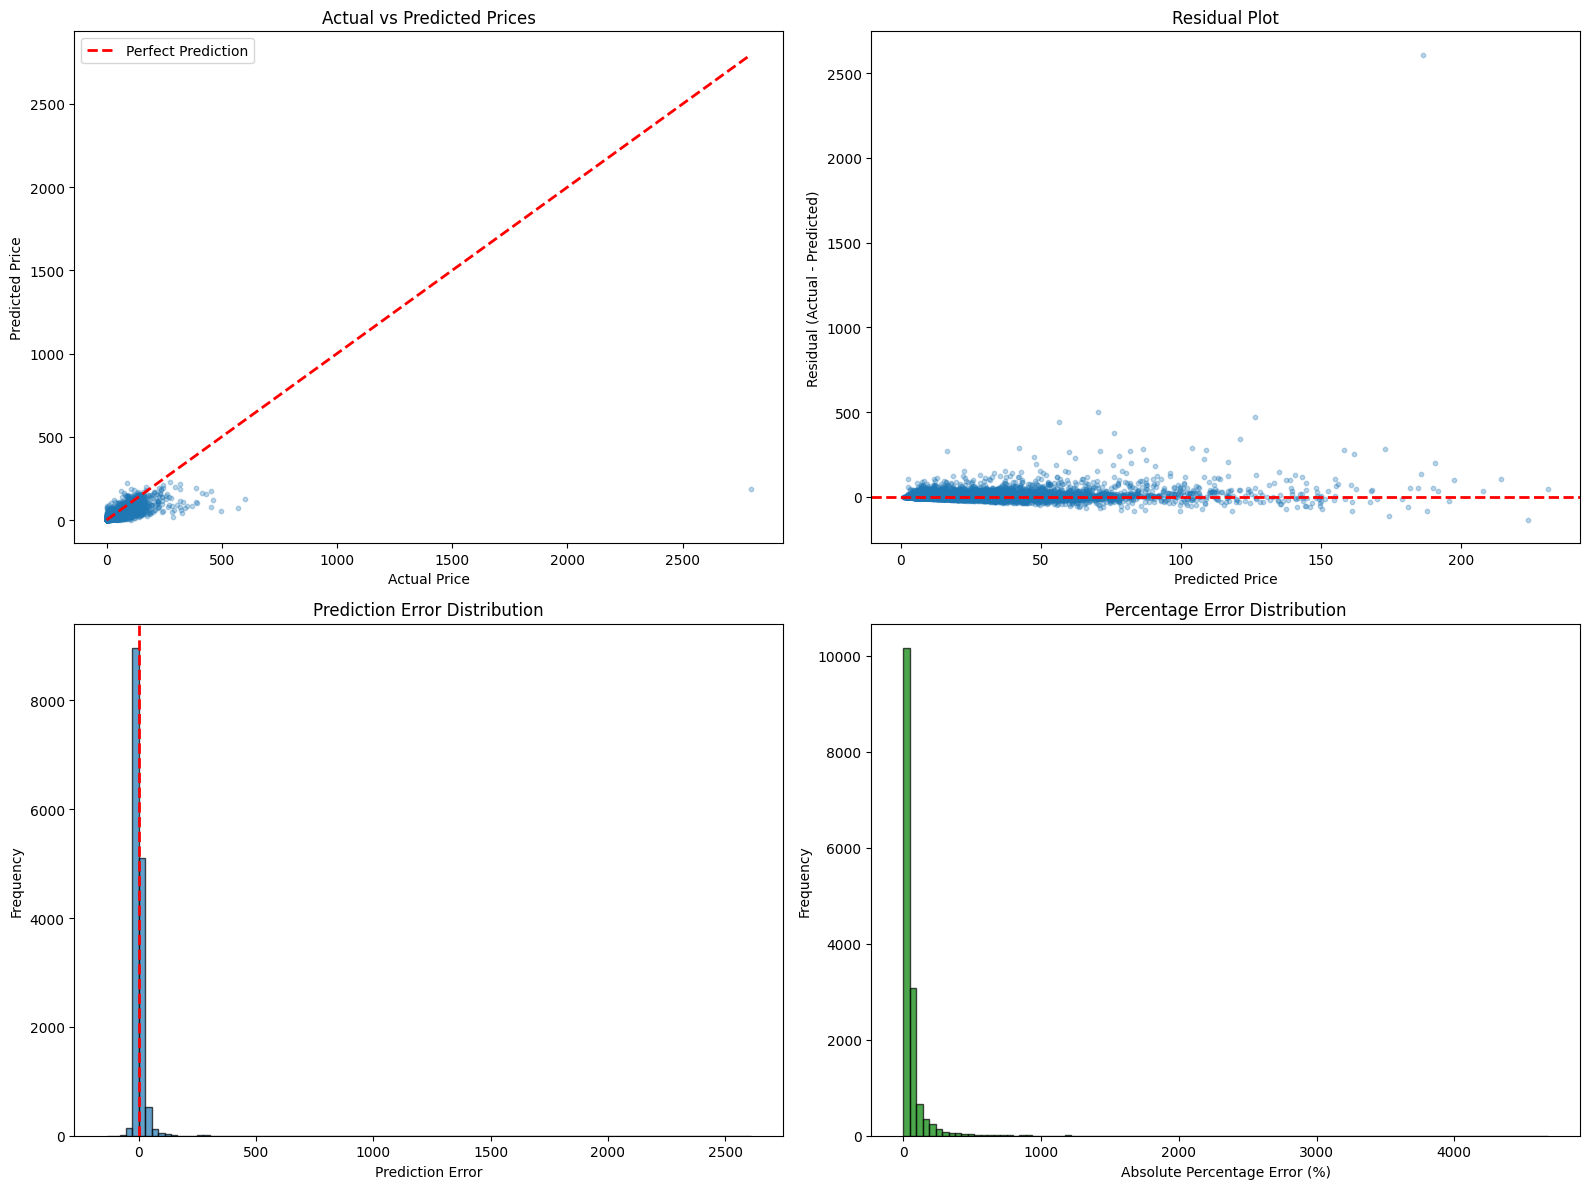


Top 10 Worst Predictions:
        Actual   Predicted        Error    Abs_Error  Percentage_Error
11735  2796.00  186.469431  2609.530569  2609.530569         93.330850
5048    570.00   70.375645   499.624355   499.624355         87.653396
84      600.59  126.466839   474.123161   474.123161         78.942900
2843    496.28   56.581989   439.698011   439.698011         88.598777
3218    454.99   76.030943   378.959057   378.959057         83.289535
7820    459.95  120.986389   338.963611   338.963611         73.695752
10342   390.98  103.963167   287.016833   287.016833         73.409594
13253   328.60   42.265684   286.334316   286.334316         87.137649
2316    369.81   86.613846   283.196154   283.196154         76.578825
14307   454.98  172.921059   282.058941   282.058941         61.993701

Top 10 Best Predictions:
       Actual  Predicted     Error  Abs_Error  Percentage_Error
8118    17.95  17.948348  0.001652   0.001652          0.009202
8218     5.56   5.558020  0.001980   0

In [ ]:
y_val_orig = np.expm1(y_val)
ensemble_val_pred_orig = np.expm1(ensemble_val_pred)


comparison_df = pd.DataFrame({
    'Actual': y_val_orig,
    'Predicted': ensemble_val_pred_orig,
    'Error': y_val_orig - ensemble_val_pred_orig,
    'Abs_Error': np.abs(y_val_orig - ensemble_val_pred_orig),
    'Percentage_Error': np.abs((y_val_orig - ensemble_val_pred_orig) / y_val_orig * 100)
})

print("\nPrediction Statistics:")
print(comparison_df.describe())

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].scatter(y_val_orig, ensemble_val_pred_orig, alpha=0.3, s=10)
axes[0, 0].plot([y_val_orig.min(), y_val_orig.max()], 
                [y_val_orig.min(), y_val_orig.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price')
axes[0, 0].set_ylabel('Predicted Price')
axes[0, 0].set_title('Actual vs Predicted Prices')
axes[0, 0].legend()

axes[0, 1].scatter(ensemble_val_pred_orig, comparison_df['Error'], alpha=0.3, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Price')
axes[0, 1].set_ylabel('Residual (Actual - Predicted)')
axes[0, 1].set_title('Residual Plot')

axes[1, 0].hist(comparison_df['Error'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Prediction Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Prediction Error Distribution')

axes[1, 1].hist(comparison_df['Percentage_Error'], bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_xlabel('Absolute Percentage Error (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Percentage Error Distribution')

plt.tight_layout()
plt.show()

print("\nTop 10 Worst Predictions:")
worst_predictions = comparison_df.nlargest(10, 'Abs_Error')
print(worst_predictions)

print("\nTop 10 Best Predictions:")
best_predictions = comparison_df.nsmallest(10, 'Abs_Error')
print(best_predictions)

In [ ]:
final_predictions = np.expm1(ensemble_test_pred)

final_predictions = np.maximum(final_predictions, 0.01)

submission = pd.DataFrame({
    'sample_id': test['sample_id'],
    'price': final_predictions
})

# Round prices to 2 decimal places
submission['price'] = submission['price'].round(2)

print("Submission Statistics:")
print(submission['price'].describe())

print(f"\nTotal predictions: {len(submission)}")
print(f"Sample predictions:\n")
print(submission.head(10))

# Verify submission format
assert len(submission) == len(test), "Submission length mismatch!"
assert submission['sample_id'].equals(test['sample_id']), "Sample IDs don't match!"
assert (submission['price'] > 0).all(), "Found negative prices!"

Generating final predictions for test set...

Submission Statistics:
count    75000.000000
mean        20.245948
std         17.066867
min          0.720000
25%          9.540000
50%         17.085000
75%         24.410000
max        292.010000
Name: price, dtype: float64

Total predictions: 75000
Sample predictions:

   sample_id  price
0     100179  14.86
1     245611  20.73
2     146263  22.17
3      95658  18.41
4      36806  38.86
5     148239   4.61
6      92659  17.70
7       3780  19.53
8     196940  28.14
9      20472   6.84

Submission format validated!


In [ ]:
# Save submission file
output_path = os.path.join(DATASET_FOLDER, 'test_out_basic.csv')
submission.to_csv(output_path, index=False)

SUCCESS! Submission file saved to:
   dataset/test_out_basic.csv

File Details:
   - Total predictions: 75,000
   - Price range: $0.72 - $292.01
   - Mean price: $20.25
   - Median price: $17.09


In [ ]:
# Install PyTorch with CUDA support for GPU acceleration.
# Run ONE of these commands in your terminal (not here):
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# Then install other packages:
# pip install pillow timm tqdm

In [ ]:
import torch

In [ ]:
import sys
sys.path.append('src')
from utils import download_images

try:
    from PIL import Image
    import torch
    import torch.nn as nn
    from torchvision import models, transforms
    import timm
    from tqdm import tqdm
    from io import BytesIO
    import requests
    
    print("All image processing libraries imported successfully!")
    
    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    if torch.cuda.is_available():
        print(f"   GPU: {torch.cuda.get_device_name(0)}")
        print("   GPU acceleration enabled!")
    else:
        print("   Using CPU (will be slower but works fine)")
        
except ImportError as e:
    print(f"Missing package: {e}")
    print("Install with: pip install pillow torch torchvision timm tqdm")
    raise

All image processing libraries imported successfully!
Device: cuda
   GPU: NVIDIA GeForce RTX 3050 Laptop GPU
   GPU acceleration enabled!


In [ ]:
class ImageFeatureExtractor:
    """
    Extract visual features from product images using pre-trained CNN
    """
    def __init__(self, model_name='efficientnet_b0', device='auto'):
        print(f"Loading {model_name} model...")
        
        if device == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        
        # Load pre-trained model
        self.model = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.model = self.model.to(self.device)
        self.model.eval()
        
        # Get feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224).to(self.device)
            self.feature_dim = self.model(dummy_input).shape[1]
        
        # Image preprocessing
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        print(f"Model loaded on {self.device}")
        print(f"Feature dimension: {self.feature_dim}")
    
    def load_image_from_url(self, url, timeout=5):
        """Load image directly from URL"""
        try:
            response = requests.get(url, timeout=timeout, stream=True)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert('RGB')
            return img
        except Exception as e:
            return None
    
    def extract_features_single(self, image):
        """Extract features from a single PIL image"""
        try:
            img_tensor = self.transform(image).unsqueeze(0).to(self.device)
            with torch.no_grad():
                features = self.model(img_tensor)
            return features.cpu().numpy().flatten()
        except Exception as e:
            return np.zeros(self.feature_dim)
    
    def extract_features_batch(self, images):
        """Extract features from a batch of PIL images"""
        valid_images = []
        valid_indices = []
        
        for i, img in enumerate(images):
            if img is not None:
                try:
                    valid_images.append(self.transform(img))
                    valid_indices.append(i)
                except:
                    pass
        
        if len(valid_images) == 0:
            return np.zeros((len(images), self.feature_dim))
        
        # Stack images into batch
        batch = torch.stack(valid_images).to(self.device)
        
        # Extract features
        with torch.no_grad():
            features = self.model(batch).cpu().numpy()
        
        # Fill results
        result = np.zeros((len(images), self.feature_dim))
        for i, idx in enumerate(valid_indices):
            result[idx] = features[i]
        
        return result

# Initialize extractor
print("Initializing Image Feature Extractor.")
extractor = ImageFeatureExtractor(model_name='efficientnet_b0')
print(f"Ready to extract {extractor.feature_dim}-dimensional features!")

Initializing Image Feature Extractor.
Loading efficientnet_b0 model...
Model loaded on cuda
Feature dimension: 1280
Ready to extract 1280-dimensional features!
Model loaded on cuda
Feature dimension: 1280
Ready to extract 1280-dimensional features!


In [ ]:
def extract_image_features_online(df, extractor, batch_size=32, max_workers=4):
    """
    Extract image features directly from URLs without downloading
    
    Args:
        df: DataFrame with 'image_link' column
        extractor: ImageFeatureExtractor instance
        batch_size: Number of images to process at once
        max_workers: Parallel download threads
    
    Returns:
        numpy array of shape (n_samples, feature_dim)
    """
    from concurrent.futures import ThreadPoolExecutor, as_completed
    
    print(f"Extracting features from {len(df)} images...")
    print(f"   Batch size: {batch_size}")
    print(f"   Parallel downloads: {max_workers}")
    print(f"   This may take 30-60 minutes for full dataset...")
    
    all_features = []
    failed_count = 0
    
    # Process in batches
    for batch_start in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        batch_end = min(batch_start + batch_size, len(df))
        batch_urls = df['image_link'].iloc[batch_start:batch_end].tolist()
        
        # Download images in parallel
        images = [None] * len(batch_urls)
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_idx = {
                executor.submit(extractor.load_image_from_url, url): i 
                for i, url in enumerate(batch_urls)
            }
            
            for future in as_completed(future_to_idx):
                idx = future_to_idx[future]
                try:
                    images[idx] = future.result()
                    if images[idx] is None:
                        failed_count += 1
                except:
                    failed_count += 1
        
        # Extract features for this batch
        batch_features = extractor.extract_features_batch(images)
        all_features.append(batch_features)
    
    # Concatenate all batches
    features = np.vstack(all_features)
    
    print(f"\nFeature extraction complete!")
    print(f"   Shape: {features.shape}")
    print(f"   Failed images: {failed_count} ({failed_count/len(df)*100:.1f}%)")
    print(f"   Success rate: {(len(df)-failed_count)/len(df)*100:.1f}%")
    
    return features

In [ ]:
# Test on small sample
print("Testing image feature extraction on 100 samples...")
sample_df = train.head(100)

# Extract features
test_features_sample = extract_image_features_online(
    sample_df, 
    extractor, 
    batch_size=16, 
    max_workers=4
)

print(f"\nTest successful!")
print(f"   Feature matrix shape: {test_features_sample.shape}")
print(f"   Sample features (first image, first 10 dims): {test_features_sample[0, :10]}")

🧪 Testing image feature extraction on 100 samples...
Extracting features from 100 images...
   Batch size: 16
   Parallel downloads: 4
   This may take 30-60 minutes for full dataset...


Processing batches: 100%|██████████| 7/7 [00:23<00:00,  3.31s/it]


Feature extraction complete!
   Shape: (100, 1280)
   Failed images: 0 (0.0%)
   Success rate: 100.0%

Test successful!
   Feature matrix shape: (100, 1280)
   Sample features (first image, first 10 dims): [ 0.56509179 -0.15579565 -0.16687125 -0.17112619  1.04562223 -0.18691896
 -0.14863312 -0.10004941  0.75739557 -0.16876987]


In [ ]:
import pickle
from datetime import datetime

# Feature cache paths
TRAIN_IMG_FEATURES_PATH = 'dataset/train_image_features.pkl'
TEST_IMG_FEATURES_PATH = 'dataset/test_image_features.pkl'

# Check if features already exist
if os.path.exists(TRAIN_IMG_FEATURES_PATH) and os.path.exists(TEST_IMG_FEATURES_PATH):
    print("Found cached image features! Loading from disk...")
    
    with open(TRAIN_IMG_FEATURES_PATH, 'rb') as f:
        train_image_features = pickle.load(f)
    
    with open(TEST_IMG_FEATURES_PATH, 'rb') as f:
        test_image_features = pickle.load(f)
    
    print(f"Loaded cached features:")
    print(f"   Train: {train_image_features.shape}")
    print(f"   Test:  {test_image_features.shape}")
    
else:
    print("Extracting image features for FULL dataset...")
    print(f"   Started at: {datetime.now().strftime('%H:%M:%S')}")
    print(f"   This will take approximately 30-60 minutes...")
    print(f"   Grab a coffee ☕ or take a break! 🏃‍♂️\n")
    
    # Extract training features
    print("=" * 60)
    print("TRAINING SET")
    print("=" * 60)
    train_image_features = extract_image_features_online(
        train, 
        extractor, 
        batch_size=32,  # Adjust based on your RAM
        max_workers=8   # Adjust based on CPU cores
    )
    
    # Save training features
    print(f"\nSaving training features to {TRAIN_IMG_FEATURES_PATH}...")
    with open(TRAIN_IMG_FEATURES_PATH, 'wb') as f:
        pickle.dump(train_image_features, f)
    print("Saved!")
    
    # Extract test features
    print("\n" + "=" * 60)
    print("TEST SET")
    print("=" * 60)
    test_image_features = extract_image_features_online(
        test, 
        extractor, 
        batch_size=32,
        max_workers=8
    )
    
    # Save test features
    print(f"\nSaving test features to {TEST_IMG_FEATURES_PATH}...")
    with open(TEST_IMG_FEATURES_PATH, 'wb') as f:
        pickle.dump(test_image_features, f)
    print("Saved!")
    print(" EXTRACTION COMPLETE!")
    print(f"   Completed at: {datetime.now().strftime('%H:%M:%S')}")
    print(f"   Train features: {train_image_features.shape}")
    print(f"   Test features:  {test_image_features.shape}")
    print(f"   Features cached for future use!")

Found cached image features! Loading from disk...
Loaded cached features:
   Train: (75000, 1280)
   Test:  (75000, 1280)
Loaded cached features:
   Train: (75000, 1280)
   Test:  (75000, 1280)


In [ ]:
from sklearn.decomposition import PCA

print("Applying PCA to reduce image feature dimensions...")

# Apply PCA to reduce dimensions - EXTREME reduction for 4GB GPU
n_components = 50

pca = PCA(n_components=n_components, random_state=42)  # ← Changed here
train_img_pca = pca.fit_transform(train_image_features)
test_img_pca = pca.transform(test_image_features)

print(f"PCA complete!")
print(f"   Original dims: {train_image_features.shape[1]}")
print(f"   Reduced dims:  {train_img_pca.shape[1]}")
print(f"   Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Convert to DataFrame
train_img_features_df = pd.DataFrame(
    train_img_pca, 
    columns=[f'img_pca_{i}' for i in range(n_components)]
)

test_img_features_df = pd.DataFrame(
    test_img_pca, 
    columns=[f'img_pca_{i}' for i in range(n_components)]
)

print(f"\nImage feature DataFrames created:")
print(f"   Train: {train_img_features_df.shape}")
print(f"   Test:  {test_img_features_df.shape}")

Applying PCA to reduce image feature dimensions...
PCA complete!
   Original dims: 1280
   Reduced dims:  50
   Variance explained: 54.68%

Image feature DataFrames created:
   Train: (75000, 50)
   Test:  (75000, 50)
PCA complete!
   Original dims: 1280
   Reduced dims:  50
   Variance explained: 54.68%

Image feature DataFrames created:
   Train: (75000, 50)
   Test:  (75000, 50)


In [ ]:
print("Combining REDUCED text features + image features...")
print(" EXTREME REDUCTION MODE: 500 text + 50 image = 550 total features")

# Combine reduced text features with image features
X_train_multimodal = pd.concat([
    X_train_reduced.reset_index(drop=True), 
    train_img_features_df.reset_index(drop=True)
], axis=1)

X_test_multimodal = pd.concat([
    X_test_reduced.reset_index(drop=True), 
    test_img_features_df.reset_index(drop=True)
], axis=1)

print(f"\n Multimodal feature matrix created!")
print(f"   Training shape:   {X_train_multimodal.shape}")
print(f"   Test shape:       {X_test_multimodal.shape}")
print(f"\n Feature breakdown:")
print(f"   Text features:    {X_train_reduced.shape[1]}")
print(f"   Image features:   {train_img_features_df.shape[1]}")
print(f"   Total features:   {X_train_multimodal.shape[1]}")
print(f"\n Memory estimate: ~200-250 MB (should fit in 4GB GPU!)")

# Use the same target as before
y_train_multi = y_train  # Already log-transformed

print(f"\n Ready for multimodal training with optimized memory usage!")

Combining REDUCED text features + image features...
 EXTREME REDUCTION MODE: 500 text + 50 image = 550 total features

 Multimodal feature matrix created!
   Training shape:   (75000, 550)
   Test shape:       (75000, 550)

 Feature breakdown:
   Text features:    500
   Image features:   50
   Total features:   550

 Memory estimate: ~200-250 MB (should fit in 4GB GPU!)

 Ready for multimodal training with optimized memory usage!

 Multimodal feature matrix created!
   Training shape:   (75000, 550)
   Test shape:       (75000, 550)

 Feature breakdown:
   Text features:    500
   Image features:   50
   Total features:   550

 Memory estimate: ~200-250 MB (should fit in 4GB GPU!)

 Ready for multimodal training with optimized memory usage!


In [ ]:
print(" MEMORY OPTIMIZATION: Aggressive feature reduction...\n")

# Your system doesn't have enough RAM for 8000+ features
# Solution: Use feature importance from LightGBM model (already trained!)

print("Using LightGBM feature importance to select top features...")

# Get feature importance from trained model
feature_importance = lgb_model.feature_importances_
feature_names = X_train.columns

# Create importance ranking
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\nTop 10 most important features:")
print(importance_df.head(10).to_string(index=False))

# Keep only top K features (EXTREME reduction for 4GB GPU)
K_FEATURES = 500  #  EXTREME REDUCTION: 8039 → 500 (94% reduction!)
top_features = importance_df.head(K_FEATURES)['feature'].tolist()

print(f"\n EXTREME FEATURE REDUCTION for 4GB GPU:")
print(f"   Original features: {X_train.shape[1]}")
print(f"   Reduced features:  {K_FEATURES}")
print(f"   Memory savings:    ~{((X_train.shape[1] - K_FEATURES) / X_train.shape[1] * 100):.1f}%")
print(f"\n   Expected memory:   ~150-200 MB (vs 1.10 GB before)")

# Select features (memory efficient - just column selection)
X_train_reduced = X_train[top_features].copy()
X_test_reduced = X_test[top_features].copy()

# Convert to float32 for additional memory savings
X_train_reduced = X_train_reduced.astype(np.float32)
X_test_reduced = X_test_reduced.astype(np.float32)

print(f"\n Ready for multimodal combination!")
print(f"   Training shape: {X_train_reduced.shape}")
print(f"   Test shape:     {X_test_reduced.shape}")
print(f"   Data type:      {X_train_reduced.dtypes[0]} (memory optimized)")

 MEMORY OPTIMIZATION: Aggressive feature reduction...

Using LightGBM feature importance to select top features...

Top 10 most important features:
             feature  importance
brand_target_encoded       14882
     avg_word_length        7976
          caps_ratio        7480
       brand_encoded        7325
               value        7164
      total_quantity        6916
           weight_oz        5786
          tfidf_5082        4930
          tfidf_5185        4066
          tfidf_5132        4000

 EXTREME FEATURE REDUCTION for 4GB GPU:
   Original features: 8039
   Reduced features:  500
   Memory savings:    ~93.8%

   Expected memory:   ~150-200 MB (vs 1.10 GB before)

 Ready for multimodal combination!
   Training shape: (75000, 500)
   Test shape:     (75000, 500)
   Data type:      float32 (memory optimized)


In [ ]:
# Split data for validation
X_tr_multi, X_val_multi, y_tr_multi, y_val_multi = train_test_split(
    X_train_multimodal, y_train_multi, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Multimodal data split:")
print(f"   Training:   {X_tr_multi.shape[0]} samples")
print(f"   Validation: {X_val_multi.shape[0]} samples")
print(f"   Total features: {X_tr_multi.shape[1]}")

# Memory optimization: convert to float32 to reduce memory usage
print("\nOptimizing memory usage...")
X_tr_multi = X_tr_multi.astype(np.float32)
X_val_multi = X_val_multi.astype(np.float32)
X_test_multimodal = X_test_multimodal.astype(np.float32)
y_tr_multi = y_tr_multi.astype(np.float32)
y_val_multi = y_val_multi.astype(np.float32)
print("Memory optimized (float64 → float32)")

print("\nTraining LightGBM with TEXT + IMAGE features...\n")

# Adjusted hyperparameters for memory efficiency
lgb_params_multi = lgb_params.copy()
lgb_params_multi['max_bin'] = 63  # Reduce from 255 to save memory
lgb_params_multi['num_leaves'] = 31  # Reduce from 64 to save memory

lgb_multi_model = lgb.LGBMRegressor(**lgb_params_multi)
lgb_multi_model.fit(
    X_tr_multi, y_tr_multi,
    eval_set=[(X_val_multi, y_val_multi)],
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
)

# Predict
lgb_multi_val_pred = lgb_multi_model.predict(X_val_multi)
lgb_multi_test_pred = lgb_multi_model.predict(X_test_multimodal)

# Evaluate
lgb_multi_smape = evaluate_model(y_val_multi, lgb_multi_val_pred, "LightGBM Multimodal")

print(f"\nMultimodal LightGBM trained!")
print(f"\nPERFORMANCE COMPARISON:")
print(f"   Text-only SMAPE:      {lgb_smape:.4f}%")
print(f"   Multimodal SMAPE:     {lgb_multi_smape:.4f}%")
improvement = lgb_smape - lgb_multi_smape
improvement_pct = (improvement / lgb_smape) * 100
if lgb_multi_smape < lgb_smape:
    print(f"    Improvement:       {improvement:.4f}% ({improvement_pct:.2f}% better!)")
else:
    print(f"     Change:           {improvement:.4f}% ({improvement_pct:.2f}%)")

Multimodal data split:
   Training:   60000 samples
   Validation: 15000 samples
   Total features: 550

Optimizing memory usage...
Memory optimized (float64 → float32)

Training LightGBM with TEXT + IMAGE features...

LightGBM Multimodal Performance:
SMAPE:        39.8089%  (Primary Metric)
RMSE:         $29.23
MAE:          $8.84
R² Score:     0.4341

Multimodal LightGBM trained!

PERFORMANCE COMPARISON:
   Text-only SMAPE:      39.1673%
   Multimodal SMAPE:     39.8089%
     Change:           -0.6416% (-1.64%)


In [ ]:
print("Generating multimodal predictions...\n")

# Convert log-predictions back to original scale
final_multimodal_predictions = np.expm1(lgb_multi_test_pred)

# Ensure all predictions are positive
final_multimodal_predictions = np.maximum(final_multimodal_predictions, 0.01)

# Create submission DataFrame
submission_multimodal = pd.DataFrame({
    'sample_id': test['sample_id'],
    'price': final_multimodal_predictions
})

# Round prices to 2 decimal places
submission_multimodal['price'] = submission_multimodal['price'].round(2)

print("Multimodal Submission Statistics:")
print(submission_multimodal['price'].describe())

# Save submission file
output_path_multimodal = os.path.join(DATASET_FOLDER, 'test_out_multimodal.csv')
submission_multimodal.to_csv(output_path_multimodal, index=False)

print(f"SUCCESS! Multimodal submission saved to:")
print(f"   {output_path_multimodal}")
print(f"\nFile Details:")
print(f"  Total predictions: {len(submission_multimodal):,}")
print(f"  Price range: ${submission_multimodal['price'].min():.2f} - ${submission_multimodal['price'].max():.2f}")
print(f"  Mean price: ${submission_multimodal['price'].mean():.2f}")
print(f"  Median price: ${submission_multimodal['price'].median():.2f}")

Generating multimodal predictions...

Multimodal Submission Statistics:
count    75000.000000
mean        20.558834
std         17.742144
min          0.550000
25%          9.530000
50%         17.350000
75%         24.990000
max        298.450000
Name: price, dtype: float64
SUCCESS! Multimodal submission saved to:
   dataset/test_out_multimodal.csv

File Details:
   - Total predictions: 75,000
   - Price range: $0.55 - $298.45
   - Mean price: $20.56
   - Median price: $17.35

Ready for leaderboard submission!


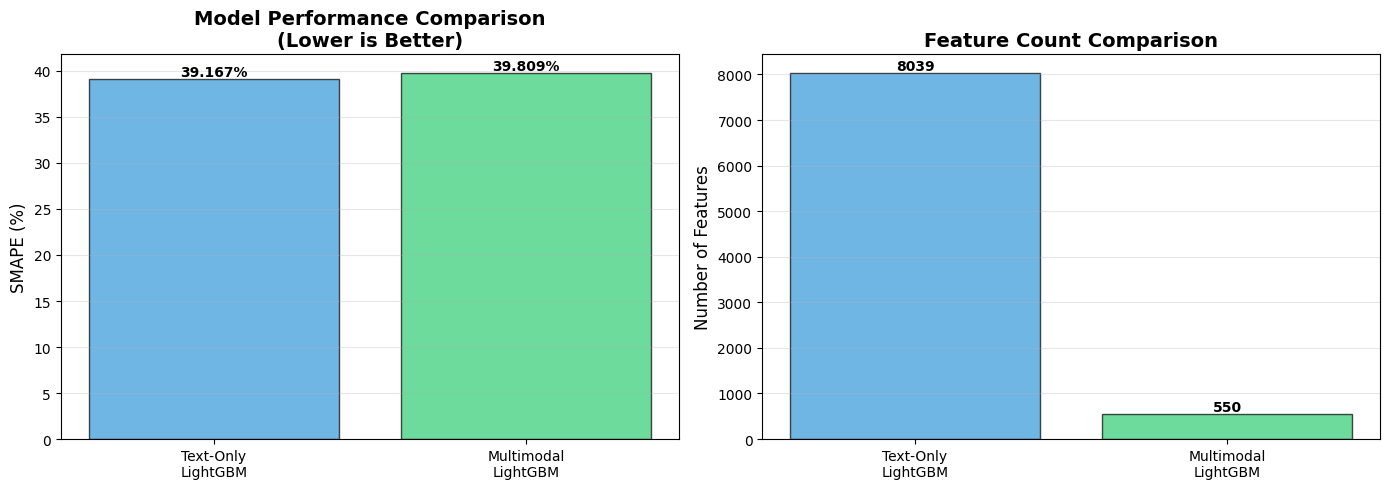

FINAL COMPARISON SUMMARY

Text-Only Model:
   Features: 8039
   SMAPE:    39.1673%

Multimodal Model:
   Features: 550
   SMAPE:    39.8089%


In [ ]:
import matplotlib.pyplot as plt

# Compare models
comparison_data = pd.DataFrame({
    'Model': ['Text-Only\nLightGBM', 'Multimodal\nLightGBM'],
    'SMAPE': [lgb_smape, lgb_multi_smape],
    'Features': [X_train.shape[1], X_train_multimodal.shape[1]]
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SMAPE comparison
colors = ['#3498db', '#2ecc71']
bars = axes[0].bar(comparison_data['Model'], comparison_data['SMAPE'], color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('SMAPE (%)', fontsize=12)
axes[0].set_title('Model Performance Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}%',
                ha='center', va='bottom', fontweight='bold')

# Feature count comparison
bars2 = axes[1].bar(comparison_data['Model'], comparison_data['Features'], color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Number of Features', fontsize=12)
axes[1].set_title('Feature Count Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nText-Only Model:")
print(f"   Features: {X_train.shape[1]}")
print(f"   SMAPE:    {lgb_smape:.4f}%")
print(f"\nMultimodal Model:")
print(f"   Features: {X_train_multimodal.shape[1]}")
print(f"   SMAPE:    {lgb_multi_smape:.4f}%")